In [55]:

# TODO: To test the subtraction algorithm manually 

In [56]:
#!/cvmfs/software.igwn.org/conda/envs/igwn-py39-lw/bin/python

import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py
from pycbc.psd import interpolate, inverse_spectrum_truncation
import sys
import xml.etree.ElementTree as ET
from io import StringIO

In [92]:
def gen_template_bank(m_1, m_2, m_radius, temp_numb):

    # Generate templates for BNS
    temp_bank = np.zeros((temp_numb, 2))

    for i in range(temp_numb):
        r1 = np.random.uniform(0, m_radius)
        r2 = np.random.uniform(0, (np.pi*2))
        m1 = r1*(np.cos(r2)) + m_1
        m2 = r1*(np.sin(r2)) + m_2

        temp_bank[i, :] = [m1, m2]

    temp_bank[i,:] = [m_1, m_2]

    return temp_bank

def MF_bank(ts, bank, psd1, show_fig=False, xmin1=0, xmax1=1):
    # this function performs matched filter on a time series with a bank of templates and returns the list of SNR time series

    for i, _ in enumerate(bank):
        print(f'Computing SNR for template {i+1}/{len(bank)}')
        # compute the SNR time series
        bank[i]['snr'], bank[i]['tpeak'], _, _, bank[i]['csnr_peak'] = gen_SNR(bank[i]['template'], ts, psd1)
        if show_fig:
            pp.figure(figsize=(15,3))
            abs(bank[i]['snr']).plot()
            pp.title(f"SNR for template {bank[i]['m1']:.1f},{bank[i]['m2']:.1f}")
            pp.xlim(xmin1, xmax1)
            pp.show()

    return bank

def best_trig(result):
    """
    Find the best trigger in a list of triggers.
    """
    maxSNR = 0
    for i, t in enumerate(result):
        if abs(t['csnr_peak']) > maxSNR:
            maxSNR = abs(t['csnr_peak'])
            maxIndex = i

    return maxIndex

def gen_noise(duration=64):

    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 256 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(duration/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples, delta_t, psd, seed=127)

    return ts, psd

def preprocess_bank(bank, N, psd1=None, flow=30):

    new_bank = []
    for i, t in enumerate(bank):
        # print(t)
        h1 = gen_waveform('IMRPhenomPv2', t[0], t[1], 0, 0, 50, 0)

        h1.resize(N)
        h1 = h1.cyclic_time_shift(h1.sample_times[-1])
        sig1 = sigma(h1, psd=psd1, low_frequency_cutoff=flow)
        h1.data /= sig1
        # self_inner, _, _, _, _ = gen_SNR(h1, h1, psd1)

        new_bank.append({'m1': t[0], 'm2': t[1], 'template': h1})
        print(f'preprocess bank loop {i+1}/{len(bank)}')
    return new_bank

def find_peak(snr, mask_between=None):

    if mask_between is not None:
        mask = (snr.sample_times >= mask_between[0]) & (snr.sample_times < mask_between[1])
        snr1 = snr.copy()
        snr1.data[mask] = 0
    else:
        snr1 = snr

    peak = abs(snr1).numpy().argmax()
    snrp = abs(snr1[peak])
    csnrp = snr1[peak]
    tpeak = snr1.sample_times[peak]

    return tpeak, peak, snrp, csnrp

def gen_SNR(template, data, psd):

    snr = matched_filter(template, data,
                         psd=psd, low_frequency_cutoff=30)

    tpeak, peak, snrp, csnrp = find_peak(snr)

    return snr, tpeak, peak, snrp, csnrp

def gen_waveform(model, m1, m2, s1z, s2z, distance, time):

    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    d = Detector("H1")

    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2, spin1z=s1z, spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ht_1 = fp * hp_1 + fc * hc_1

    return ht_1

def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total, ht_2

def inject(ht_total,ts,injtime):

    # append extra zeros than required
    ht_total.append_zeros(int((ts.duration-injtime)*1.5*4096))

    ht_total = ht_total.cyclic_time_shift(int(injtime + ht_total.start_time))
    ht_total = ht_total.resample(ts.delta_t)

    #Resizing the signal
    ht_total.resize(len(ts))

    #Equating the start time
    ht_total = ht_total.cyclic_time_shift(ht_total.start_time + injtime)
    ht_total.start_time = ts.start_time

    #Injecting signal into noise
    ts = ts.add_into(ht_total)

    return ts

def shift_timeseries(tsx, tau):

    if 'float' in str(tsx.dtype):
        tsx_shifted = tsx.cyclic_time_shift(tau-tsx.duration)

    elif 'complex' in str(tsx.dtype):
        tsx_shifted_r = tsx.real().cyclic_time_shift(tau-tsx.duration)
        tsx_shifted_i = tsx.imag().cyclic_time_shift(tau-tsx.duration)
        tsx_shifted = tsx_shifted_r + 1j * tsx_shifted_i

    tsx_shifted.start_time = 0

    return tsx_shifted

def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)

    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)

    ht_template = fp * hp + fc * hc
    ht_template.resize(len(conditioned))
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)

    return template

def match_other_best_template_simple(itrig1, bank, psd, width=0.15, show_figs=False):
    rho_N = bank[itrig1]['snr']
    h1_bns = bank[itrig1]['template']
    tpeak = bank[itrig1]['tpeak']
    snr_peak_N = abs(bank[itrig1]['csnr_peak'])
    xmin, xmax = tpeak-0.5, tpeak+0.5
    max_snr = 0
    buffer = 0

    for i, t in enumerate(bank):

        # print(f"({t['m1']}, {t['m2']})")
        rho_B = t['snr']
        h1_bbh = t['template']

        # if show_figs:
        #     pp.figure(figsize=(15, 3))
        #     abs(rho_B).plot()
        #     abs(rho_N).plot()
        #     pp.xlim(xmin, xmax)
            # pp.show()
        #print(f'Computing inner product for template {i+1}/{len(bank)}')
        x_nb, _, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd)
        shifted_nb = shift_timeseries(x_nb, tpeak)

        rho_sub = rho_B - snr_peak_N * shifted_nb

        # chisq_vals = gen_chisquare(h1_bbh, ?, t["m1"], t["m2"], 0, 0, psd)
        # new_snr = newsnr(abs(rho_sub), chisq_vals)

        tpeak2, _, snrp, csnrp = find_peak(rho_sub) #, mask_between=(tpeak-width, tpeak+width)

        bank[i]['csnr_peak'] = csnrp
        bank[i]['tpeak'] = tpeak2

        if snrp > max_snr:
            itrig2 = i
            max_snr = snrp
            tpeak2_best = tpeak2
            shifted_nb_best = shifted_nb
            rho_sub_best = rho_sub
            buffer_best = buffer
            rho_b_best = rho_B

            if show_figs:
                print(f"({t['m1']}, {t['m2']}) {snrp} {tpeak2} {buffer}")
                pp.figure(figsize=(15, 6))
                pp.subplot(311)
                pp.title(f"peak {snr_peak_N:.2f}")
                abs(rho_B).plot()
                # abs(rho_N).plot()
                abs(rho_sub).plot()
                # (rho_sub).plot()
                pp.xlim(xmin, xmax)
                pp.subplot(312)
                abs(snr_peak_N * shifted_nb).plot()
                pp.xlim(xmin, xmax)
                # pp.ylim(-0.3, 11)
                pp.subplot(313)
                abs(rho_sub).plot()
                pp.xlim(xmin, xmax)
                # pp.ylim(-0.3, 11)
                pp.show()
    
    pp.figure(figsize=(18,6))
    pp.subplot(311)
    pp.plot(shifted_nb_best.sample_times, max_snr*shifted_nb_best.real(), label='real(shifted_nb_best)*SNR')
    pp.plot(rho_b_best.sample_times, rho_b_best.real(), label='real(rho_b_best)')
    pp.legend(loc='upper left')
    pp.xlim(11, 13.5)

    pp.subplot(312)
    pp.plot(shifted_nb_best.sample_times, max_snr*shifted_nb_best.imag(), label='imag(shifted_nb_best)*SNR')
    pp.plot(rho_b_best.sample_times, rho_b_best.imag(), label='imag(rho_b_best)')
    pp.legend(loc='upper left')
    pp.xlim(11, 13.5)

    pp.subplot(313)
    pp.plot(rho_sub_best.sample_times, rho_sub_best.real(), label='real(rho_sub_best)')
    pp.plot(rho_sub_best.sample_times, rho_sub_best.imag(), label='imag(rho_sub_best)')
    pp.plot(rho_sub_best.sample_times, abs(rho_sub_best), label='abs(rho_sub_best)')
    pp.legend(loc='upper left')
    pp.xlim(11, 13.5)
    pp.show()

    return itrig2, max_snr, tpeak2_best, buffer_best, bank

In [93]:
m1_1 = 35
m2_1 = 32
m1_2 = 39
m2_2 = 31

snr_desired1 = 15
snr_desired2 = 12

buffer = 1

inj_time = 13

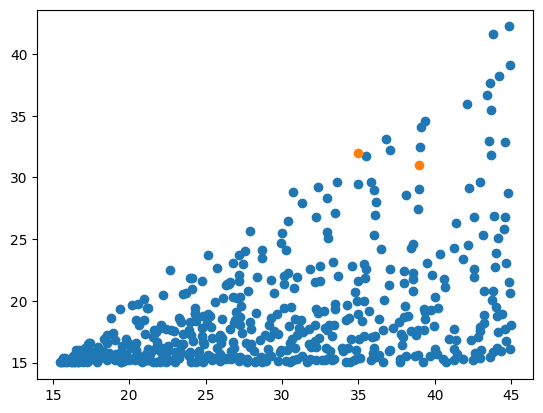

In [94]:
from pycbc.waveform.bank import TemplateBank

tbank = TemplateBank('999mat1545.xml')

mass1_bank, mass2_bank = [], []
temp_bank = np.zeros((len(tbank.table['mass1']), 2))

for i in range(len(tbank.table['mass1'])):
    temp_bank[i, :] = [tbank.table['mass1'][i], tbank.table['mass2'][i]]

pp.scatter(tbank.table['mass1'], tbank.table['mass2'])
pp.scatter([m1_1,m1_2], [m2_1, m2_2])
pp.show()

In [95]:
print(len(tbank.table['mass1']))

511


In [96]:


flow_global = 30
noise, psd = gen_noise(duration=16)
# print(noise.duration)
psd = interpolate(psd, noise.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * noise.sample_rate),
                                  low_frequency_cutoff=flow_global)

def gen_signal_for_injection(m1_inj, m2_inj, s1z_inj, s2z_inj, inc_inj, dist_inj):
    h_plus, h_cross = get_td_waveform(approximant='IMRPhenomPv2', 
                                            mass1= m1_inj, 
                                            mass2= m2_inj, 
                                            spin1z= s1z_inj,
                                            spin2z= s2z_inj,
                                            inclination= inc_inj,
                                            distance= dist_inj, 
                                            f_lower= flow_global, 
                                            delta_t=noise.delta_t)
    return h_plus, h_cross

def get_optimal_snr(waveform, psd):

    waveform_to_use = waveform.copy()
    opt_snr = pycbc.filter.matchedfilter.overlap(waveform_to_use, waveform_to_use, psd=psd, low_frequency_cutoff=flow_global, normalized=False)**0.5
    return opt_snr

In [97]:
h1_bbh = gen_waveform('IMRPhenomPv2', m1_1, m2_1, 0, 0, 1000, 0)
h1_bns = gen_waveform('IMRPhenomPv2', m1_2, m2_2, 0, 0, 1000, 0)
h1_bbh.resize(len(noise))
h1_bns.resize(len(noise))
# pp.plot(h1_bbh.sample_times, h1_bbh)
# pp.show()

factor1 = snr_desired1/get_optimal_snr(h1_bbh, psd)
#print(f'factor1: {factor1}, opt_snr1: {get_optimal_snr(h1_bbh, psd)}')
factor2 = snr_desired2/get_optimal_snr(h1_bns, psd)
#print(f'factor2: {factor2}, opt_snr1: {get_optimal_snr(h1_bns, psd)}')

ht_total, _ = overlap((h1_bbh.copy()*factor1), (h1_bns.copy()*factor2), buffer)
ts1 = inject(ht_total, noise, injtime = inj_time)

print('bank preprocessing')
bank = preprocess_bank(temp_bank, len(ts1), psd1=psd)
print('match_filtering...')
result1 = MF_bank(ts1, bank, psd, show_fig=False, xmin1=35.5, xmax1=36.5)
itrigger1 = best_trig(result1)

'''To check the matches of templates with the first signal'''

# for i, temp in enumerate(temp_bank):
#     test_temp = gen_waveform('IMRPhenomPv2', temp[0], temp[1], 0, 0, 1000, 0)
#     test_temp.resize(len(noise))
#     print(i, pycbc.filter.matchedfilter.match(test_temp, h1_bbh, psd, low_frequency_cutoff=flow_global)[0])
#     if i >= len(temp_bank) :
#         break

bank preprocessing
preprocess bank loop 1/511
preprocess bank loop 2/511
preprocess bank loop 3/511
preprocess bank loop 4/511
preprocess bank loop 5/511
preprocess bank loop 6/511
preprocess bank loop 7/511
preprocess bank loop 8/511
preprocess bank loop 9/511
preprocess bank loop 10/511
preprocess bank loop 11/511
preprocess bank loop 12/511
preprocess bank loop 13/511
preprocess bank loop 14/511
preprocess bank loop 15/511
preprocess bank loop 16/511
preprocess bank loop 17/511
preprocess bank loop 18/511
preprocess bank loop 19/511
preprocess bank loop 20/511
preprocess bank loop 21/511
preprocess bank loop 22/511
preprocess bank loop 23/511
preprocess bank loop 24/511
preprocess bank loop 25/511
preprocess bank loop 26/511
preprocess bank loop 27/511
preprocess bank loop 28/511
preprocess bank loop 29/511
preprocess bank loop 30/511
preprocess bank loop 31/511
preprocess bank loop 32/511
preprocess bank loop 33/511
preprocess bank loop 34/511
preprocess bank loop 35/511
preprocess

'To check the matches of templates with the first signal'

loop0, finding best trigger (signal 2)


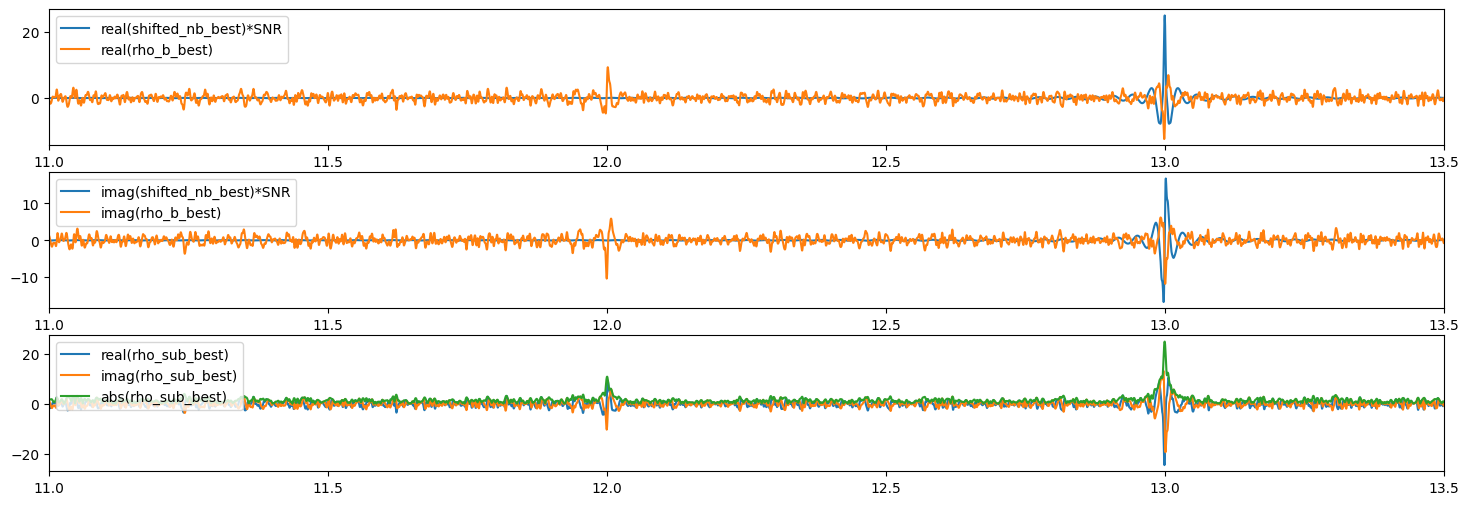

trig2:  236 42.579586029052734 26.813507080078125 24.867201774000158 12.99951171875
----------------------------------------------------------------------------------------------------

loop0, finding best trigger (signal 1)


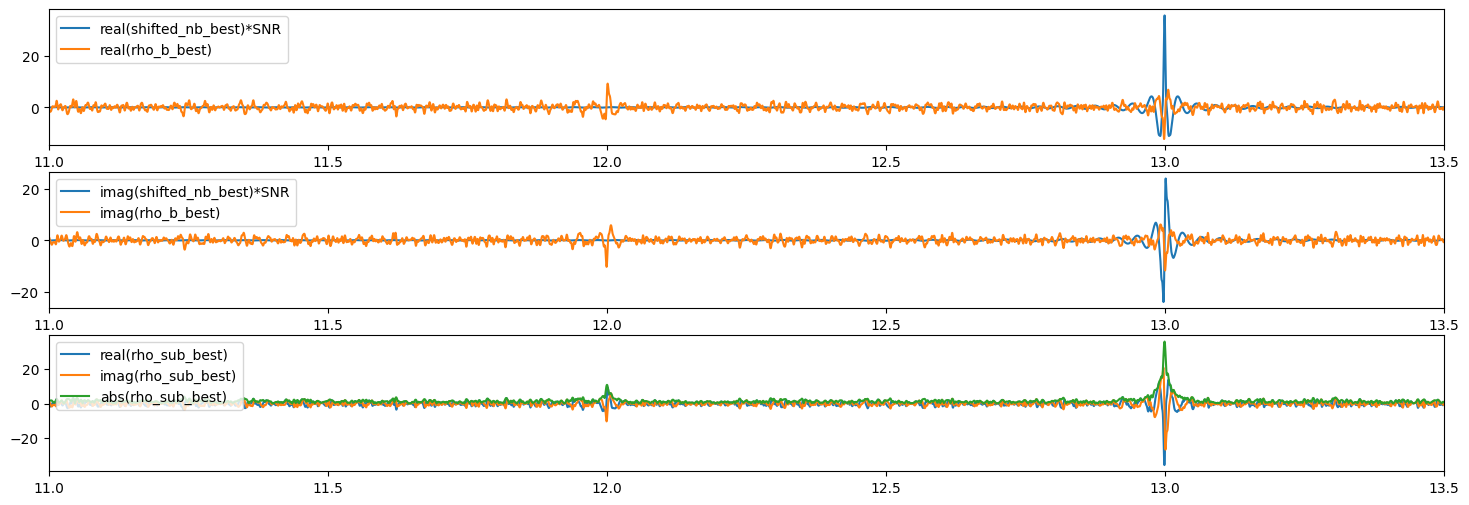

			trig1:  236 42.579586029052734 26.813507080078125 35.87187194024797 12.99951171875
----------------------------------------------------------------------------------------------------

loop1, finding best trigger (signal 2)


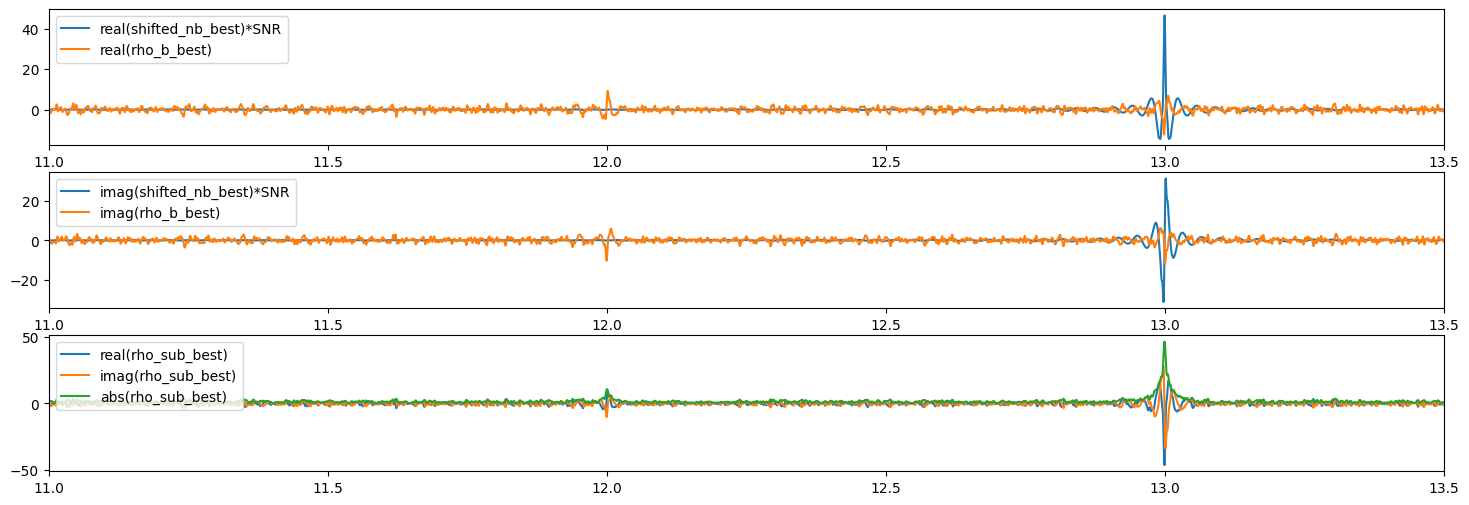

trig2:  236 42.579586029052734 26.813507080078125 46.608787766823525 12.99951171875
----------------------------------------------------------------------------------------------------

loop1, finding best trigger (signal 1)


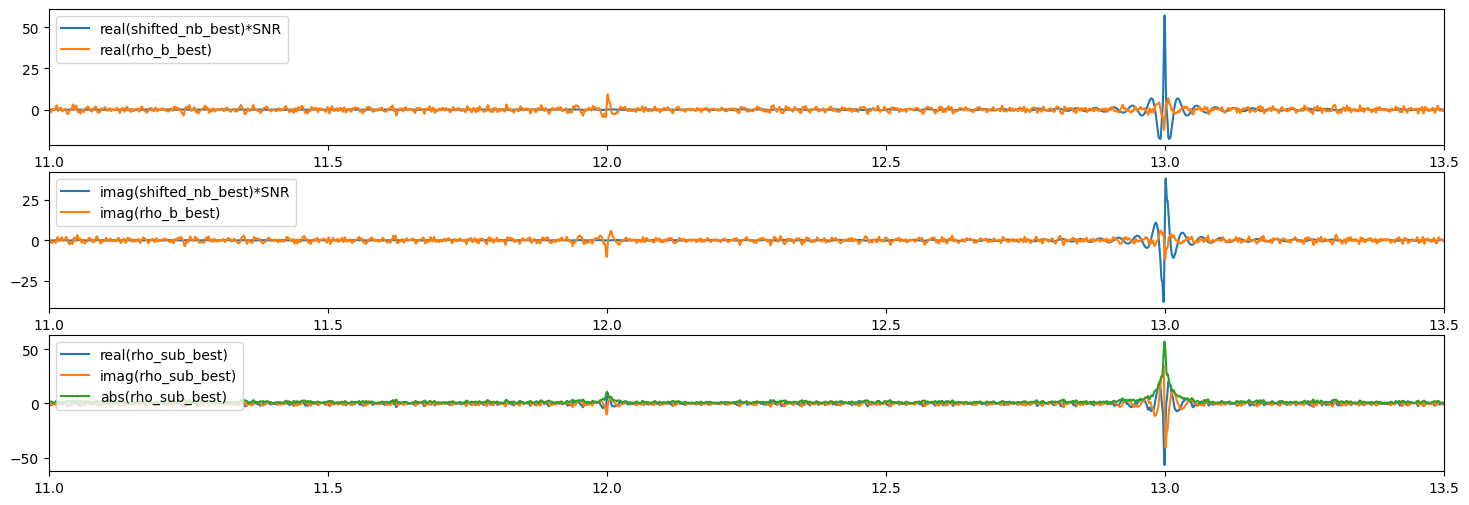

			trig1:  236 42.579586029052734 26.813507080078125 57.182666609460924 12.99951171875
----------------------------------------------------------------------------------------------------

loop2, finding best trigger (signal 2)


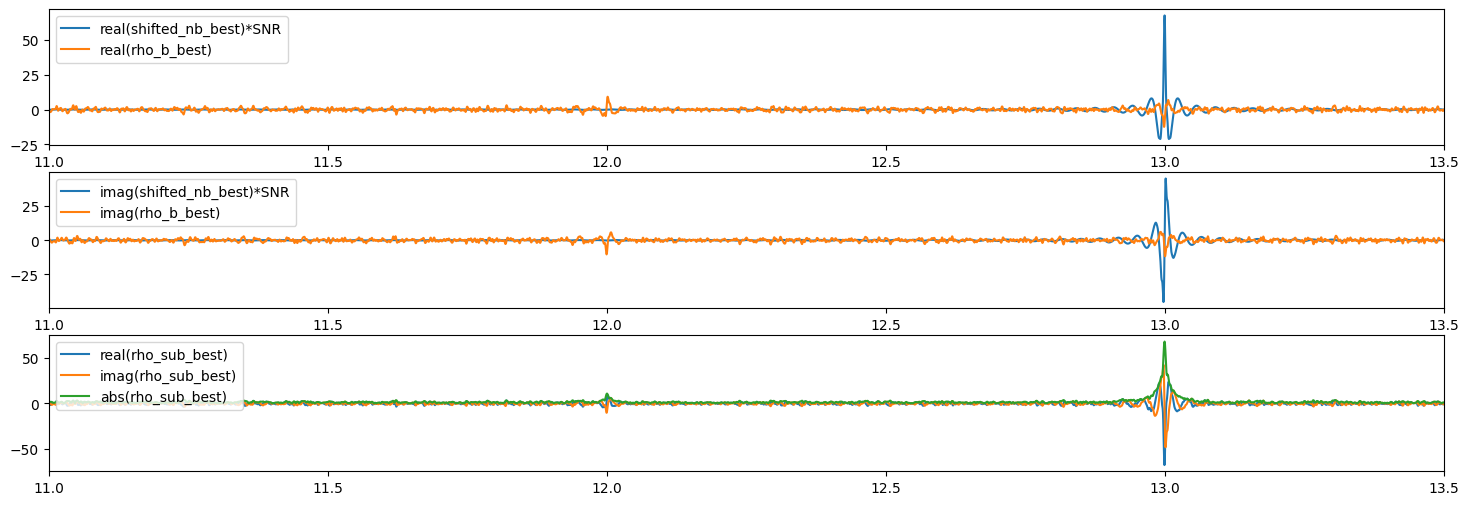

trig2:  236 42.579586029052734 26.813507080078125 67.64620087340543 12.99951171875
----------------------------------------------------------------------------------------------------

loop2, finding best trigger (signal 1)


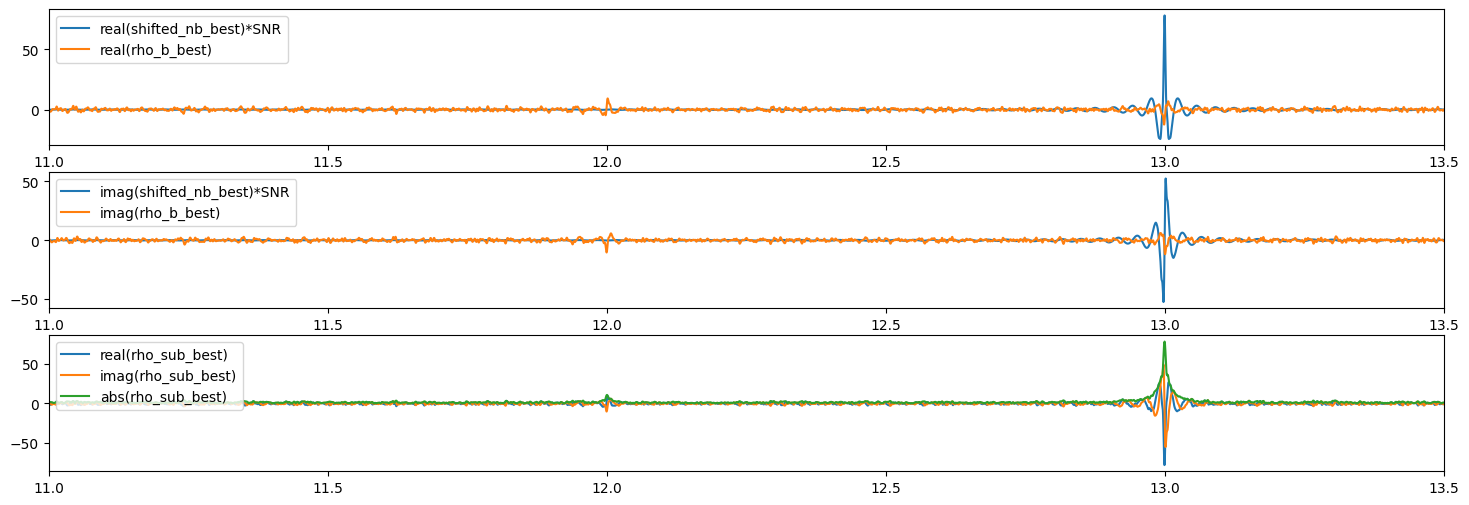

			trig1:  236 42.579586029052734 26.813507080078125 78.02983320750546 12.99951171875
----------------------------------------------------------------------------------------------------

loop3, finding best trigger (signal 2)


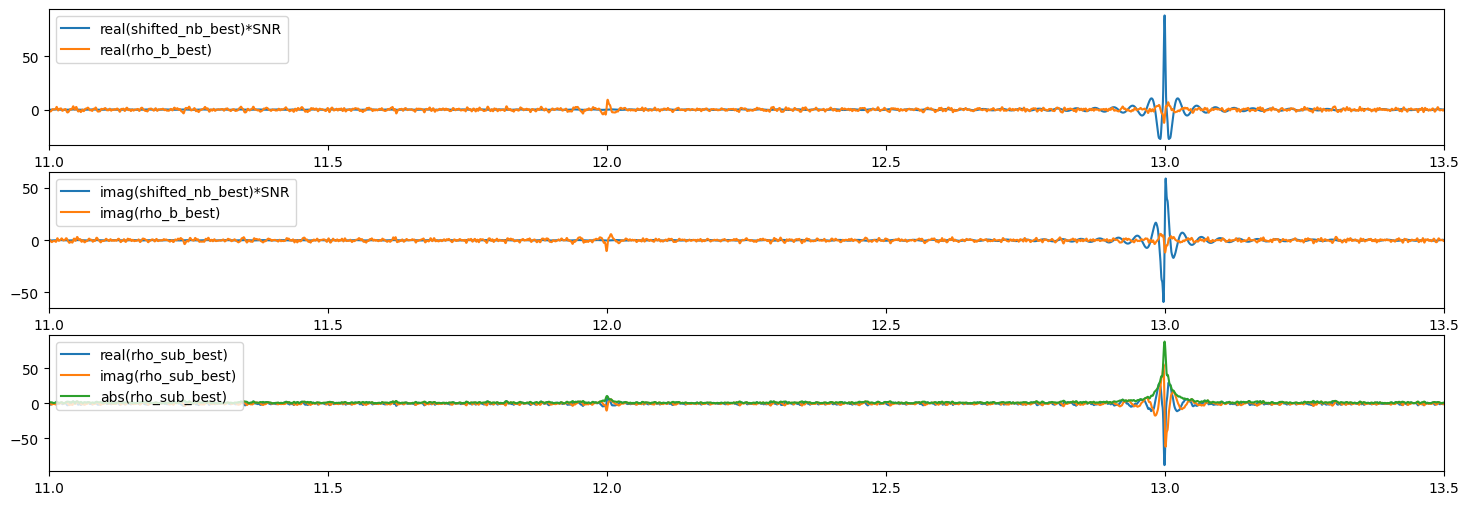

trig2:  236 42.579586029052734 26.813507080078125 88.35281347652719 12.99951171875
----------------------------------------------------------------------------------------------------

loop3, finding best trigger (signal 1)


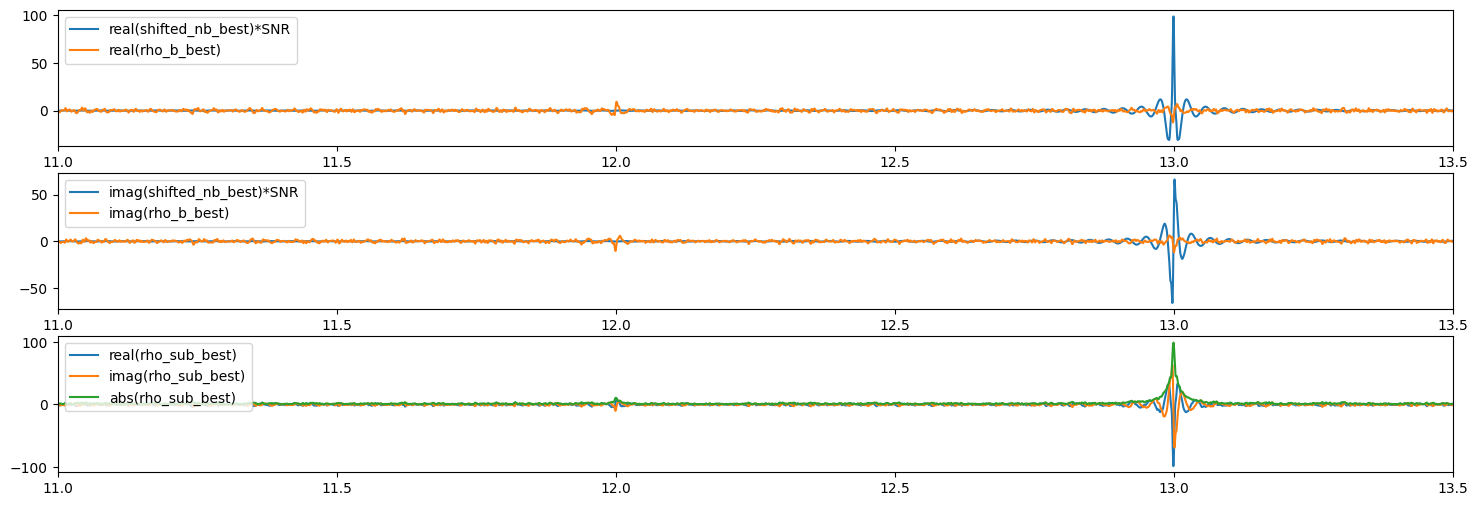

			trig1:  236 42.579586029052734 26.813507080078125 98.6281190922218 12.99951171875
----------------------------------------------------------------------------------------------------

loop4, finding best trigger (signal 2)


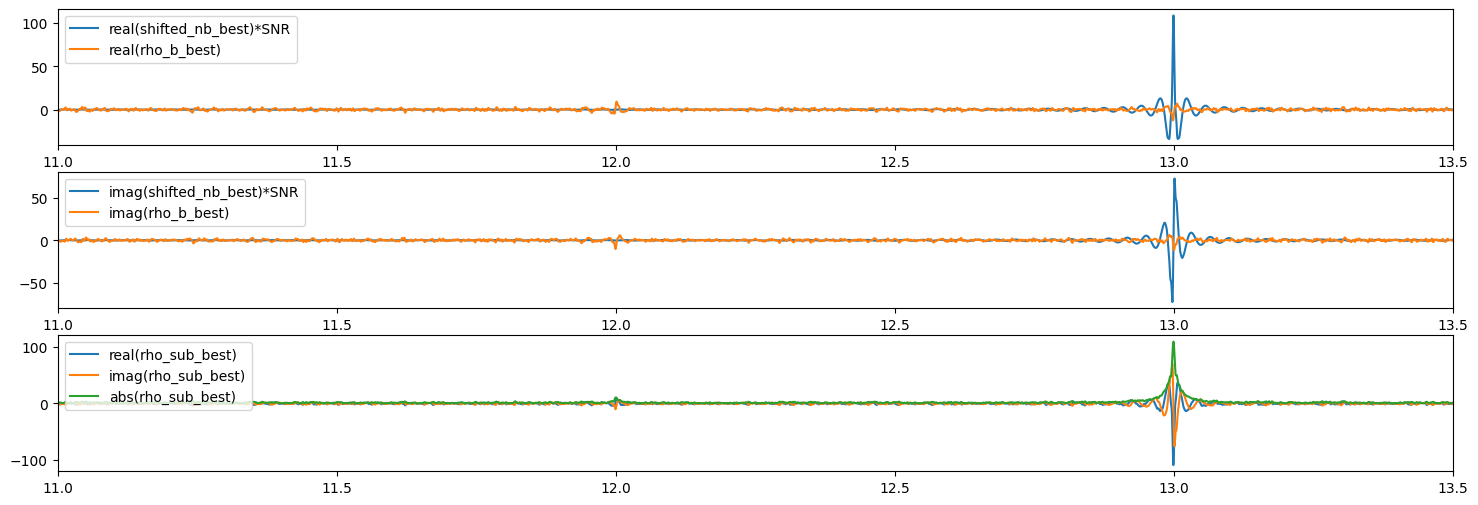

trig2:  236 42.579586029052734 26.813507080078125 108.86492870673221 12.99951171875
----------------------------------------------------------------------------------------------------

loop4, finding best trigger (signal 1)


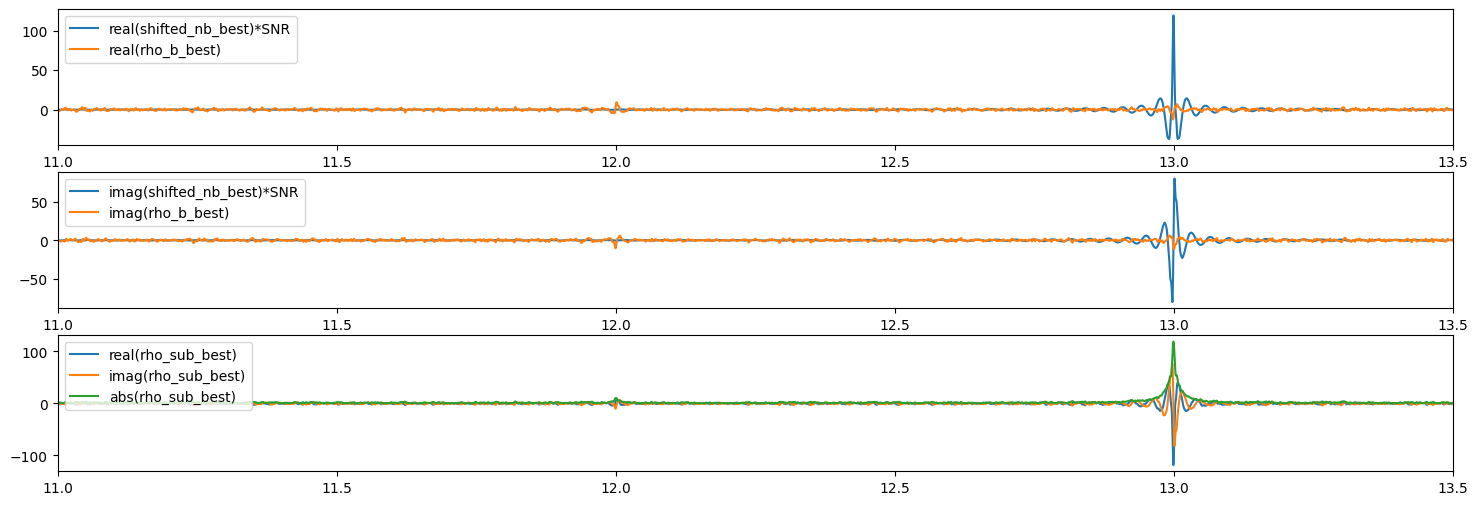

			trig1:  236 42.579586029052734 26.813507080078125 119.06998118824181 12.99951171875
----------------------------------------------------------------------------------------------------



In [98]:
result = {'trig':[],'index':[],'snr_rec':[], 'snr1':[], 'snr2':[], 'time':[], 'masses_inj':[], 'recovery':[]}   
result["trig"].append('trig1')
# result["best_trig1"].append(best_trig1)
# result["best_trig2"].append(best_trig2)
result["index"].append(itrigger1)
result["masses_inj"].append((m1_1, m2_1, m1_2, m2_2))
result["recovery"].append((result1[itrigger1]['m1'], result1[itrigger1]['m2']))
# result["best_recovery"].append((mass1_bank[best_trig1], mass2_bank[best_trig1],mass1_bank[best_trig2], mass2_bank[best_trig2]))
result["snr_rec"].append(abs(result1[itrigger1]['csnr_peak']))
result['snr1'].append(snr_desired1)
result['snr2'].append(snr_desired2)
result["time"].append(result1[itrigger1]['tpeak'])

FIGS = False
for i in range(5):
    # choose best 2nd trigger
    print(f'loop{i}, finding best trigger (signal 2)')
    itrigger2, max_snr, tpeak2_best, buffer_best, result2 = match_other_best_template_simple(itrigger1, result1, psd, show_figs=FIGS)
    print("trig2: ", itrigger2, result2[itrigger2]['m1'], result2[itrigger2]['m2'], abs(result2[itrigger2]['csnr_peak']), result2[itrigger2]['tpeak'])
    print('----------------------------------------------------------------------------------------------------')
    print()
    result["trig"].append('trig2')
    # result["best_trig1"].append(best_trig1)
    # result["best_trig2"].append(best_trig2)
    result["index"].append(itrigger2)
    result["masses_inj"].append((m1_1, m2_1, m1_2, m2_2))
    result["recovery"].append((result2[itrigger2]['m1'], result2[itrigger2]['m2']))
    # result["best_recovery"].append((mass1_bank[best_trig1], mass2_bank[best_trig1],mass1_bank[best_trig2], mass2_bank[best_trig2]))
    result["snr_rec"].append(abs(result2[itrigger2]['csnr_peak']))
    result['snr1'].append(snr_desired1)
    result['snr2'].append(snr_desired2)
    result["time"].append(result2[itrigger2]['tpeak'])


    # adjust 1st trigger
    print(f'loop{i}, finding best trigger (signal 1)')
    itrigger1, max_snr, tpeak2_best, buffer_best, result1 = match_other_best_template_simple(itrigger2, result2, psd, show_figs=FIGS)
    print("\t\t\ttrig1: ", itrigger1, result1[itrigger1]['m1'], result1[itrigger1]['m2'], abs(result1[itrigger1]['csnr_peak']), result1[itrigger1]['tpeak'])
    print('----------------------------------------------------------------------------------------------------')
    print()
    result["trig"].append('trig1')
    # result["best_trig1"].append(best_trig1)
    # result["best_trig2"].append(best_trig2)
    result["index"].append(itrigger1)
    result["masses_inj"].append((m1_1, m2_1, m1_2, m2_2))
    result["recovery"].append((result1[itrigger1]['m1'], result1[itrigger1]['m2']))
    # result["best_recovery"].append((mass1_bank[best_trig1], mass2_bank[best_trig1],mass1_bank[best_trig2], mass2_bank[best_trig2]))
    result["snr_rec"].append(abs(result1[itrigger1]['csnr_peak']))
    result['snr1'].append(snr_desired1)
    result['snr2'].append(snr_desired2)
    result["time"].append(result1[itrigger1]['tpeak'])

    data = pd.DataFrame.from_dict(result)
    data.to_csv('sub_alg.csv')

    